In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
from cycspec_simulator import (
    TemplateProfile,
    BasebandModel,
    FreqOnlyPredictor,
    PolynomialPredictor,
    ExponentialScatteringModel,
    pspec_numba,
    Time
)

%matplotlib notebook

In [2]:
template_file = "B1937+21.Rcvr1_2.GUPPI.15y.x.sum.sm"
template = TemplateProfile.from_file(template_file)
template.normalize()
template.make_posdef()

Adjusting I**2 by 5.5361972783884994e-08


In [3]:
bandwidth = 1.5625e6 # Hz
obsfreq = 1.50078125e9 # Hz
#pulse_freq = 641.948222127829 # Hz
#predictor = FreqOnlyPredictor(pulse_freq, epoch=Time(60000, 0, 0))
predictor = PolynomialPredictor.from_file("polyco-B1937+21-60000.dat")
model = BasebandModel(template, bandwidth=bandwidth, predictor=predictor, obsfreq=obsfreq)

In [4]:
scattering_model = ExponentialScatteringModel(scattering_time=40e-6, bandwidth=model.bandwidth, cutoff=20)
pattern = scattering_model.realize()

<IPython.core.display.Javascript object>


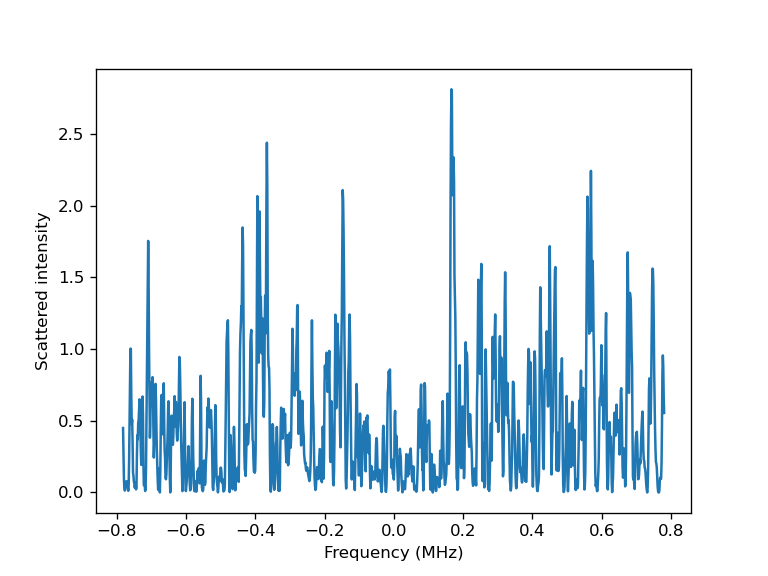

In [5]:
pattern.plot_scattered_intensity()

In [6]:
data = model.sample(2**22)
data = pattern.scatter(data)

In [7]:
%time pspec = pspec_numba(data, 1024, 1024, predictor)

CPU times: user 1min 26s, sys: 442 ms, total: 1min 27s
Wall time: 1min 26s


<IPython.core.display.Javascript object>


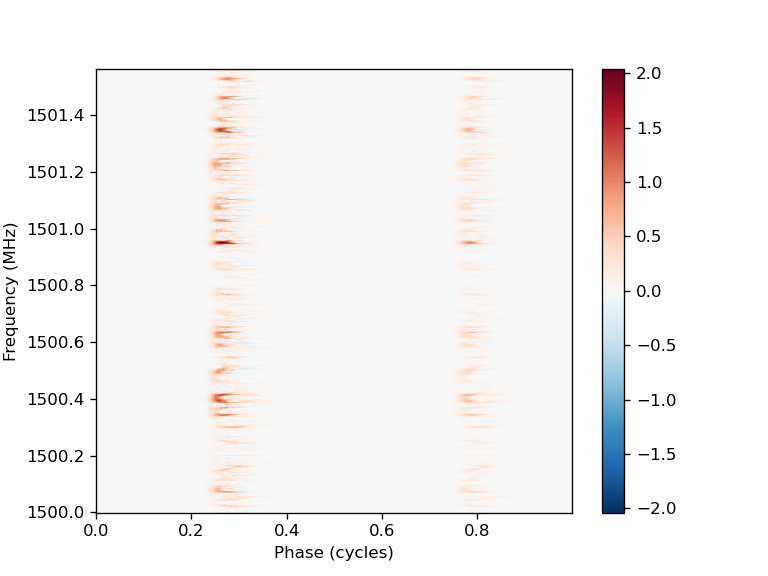

In [8]:
pc = pspec.plot(shift=0.25, cmap='RdBu_r', sym_lim=True)
plt.colorbar(pc)
plt.show()

<IPython.core.display.Javascript object>


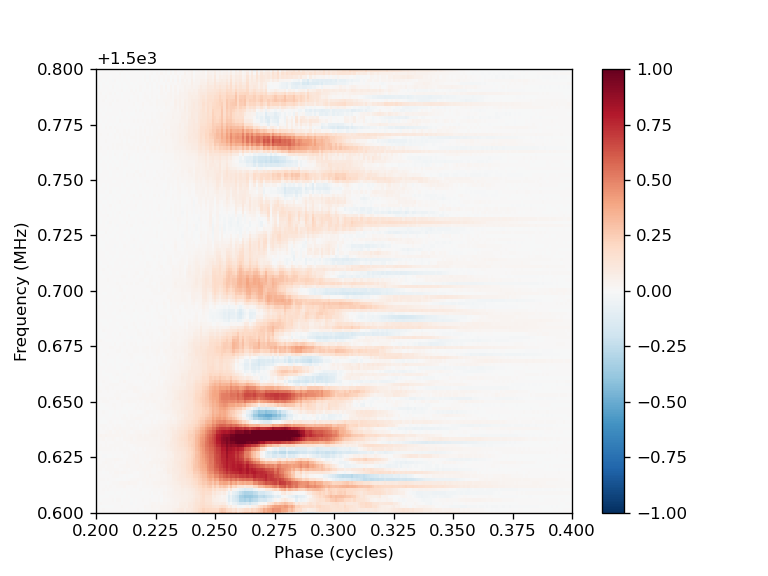

In [9]:
pc = pspec.plot(what='I', shift=0.25, cmap='RdBu_r', sym_lim=True, vmin=-1, vmax=1)
plt.colorbar(pc)
plt.xlim([0.2, 0.4])
plt.ylim([1500.6, 1500.8])
plt.show()

<IPython.core.display.Javascript object>


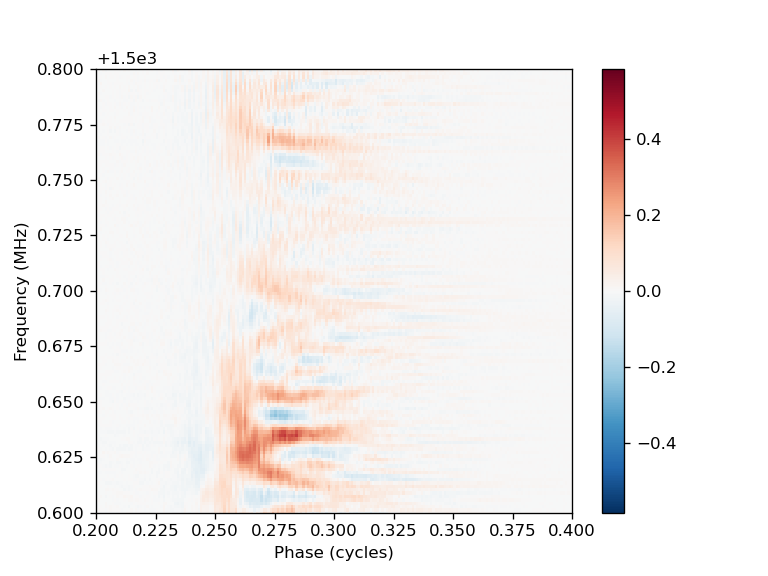

In [10]:
pc = pspec.plot(what='U', shift=0.25, cmap='RdBu_r', sym_lim=True, vmin=-1, vmax=1)
plt.colorbar(pc)
plt.xlim([0.2, 0.4])
plt.ylim([1500.6, 1500.8])
plt.show()

In [11]:
predictor.epoch.offset

0.99999706633389

In [12]:
str(data.bandwidth/1e6)

'1.5625'

In [13]:
data.t[0].offset

1.00079642633389

In [14]:
from cycspec_simulator import guppi_raw

In [15]:
header = guppi_raw.GuppiRawHeader({
    'SRC_NAME': 'B1937+21',
    'TELESCOP': 'GBT',
    'BACKEND': 'GUPPI',
    'OBSERVER': 'cycspec-simulator',
    'OBSFREQ': str(data.obsfreq/1e6),
    'OBSBW': str(data.bandwidth/1e6),
    'STT_IMJD': data.t.mjd,
    'STT_SMJD': data.t.second + int(data.t[0].offset),
    'STT_OFFS': data.t[0].offset - int(data.t[0].offset),
    'PKTIDX': 0,
    'PKTFMT': '1SFA',
})
guppi_raw.write('B1937+21-40us.raw', data, header)

In [16]:
!du -sh *

16M	B1937+21-40us.raw
4.0K	B1937+21_pred.par
68K	B1937+21.Rcvr1_2.GUPPI.15y.x.sum.sm
100K	benchmarking.ipynb
4.0K	polyco-B1937+21-60000.dat
848K	simulate.ipynb
584K	symmetric-vs-asymmetric.ipynb
856K	template-recovery.ipynb


In [17]:
!head B1937+21-40us.raw

SRC_NAME= 'B1937+21'                                                            TELESCOP= 'GBT     '                                                            BACKEND = 'GUPPI   '                                                            OBSERVER= 'cycspec-simulator'                                                   OBSFREQ = '1500.78125'                                                          OBSBW   = '1.5625  '                                                            STT_IMJD=                60000                                                  STT_SMJD=                 1800                                                  STT_OFFS= 0.000796426333889988                                                  PKTIDX  =                    0                                                  PKTFMT  = '1SFA    '                                                            NPOL    = '4       '                                                            NBITS   =                    8          

In [18]:
headers, new_data = guppi_raw.read('B1937+21-40us.raw', use_dask=False)

In [19]:
np.all(new_data == guppi_raw.quantize(data))

True